# VWAP Profile Part II

In [19]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
from sklearn import linear_model as linear_model

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

# data source: alphavantage.co|

In [20]:
ticker = "MSFT"
raw_bar_data = pd.read_csv( './Feb_2_2018_Data/' + ticker +'.csv', index_col = 0, parse_dates = True )

# let's flip the time series
raw_bar_data = raw_bar_data.sort_index( ascending=True )

In [21]:
# add a minute bin
# US start of date, calc in minutes
start_of_day = (9 * 60) + 30
# get the time for each bin in minutes and subtract 9:30
raw_bar_data[ 'minute_bars' ] = (raw_bar_data.index.hour * 60) + raw_bar_data.index.minute - start_of_day

# now trim anything beyond bin 389
raw_bar_data = raw_bar_data[ raw_bar_data.minute_bars <= 389 ]

In [22]:
# calculate the cumulative pct by day
totl_volume = raw_bar_data.groupby( [ raw_bar_data.index.date ] ).tail( 1 )[ 'volume' ] 
raw_bar_data[ 'accum_volume' ] = raw_bar_data.groupby( [ raw_bar_data.index.date ] ).cumsum()[ 'volume' ] 
raw_bar_data[ 'accum_pct' ] = raw_bar_data.groupby( [ raw_bar_data.index.date ] )[ 'accum_volume' ].transform( lambda x: x / x.iloc[ -1 ] )

In [23]:
# let's use only a part of the data since we want to pretend to be rigorous and use out of sample testing
# NOTE: the copy is important: group operations below won't work on a slice
bar_data = raw_bar_data[ '01-24-2018':'02-04-2018' ].copy()

## First by regression 

In [24]:
# arrange our data
minute_bars = bar_data[ 'minute_bars' ]
X = pd.DataFrame( { 'bin': minute_bars, 
                    'bin2' : minute_bars**2, 
                    'bin3' : minute_bars**3, 
                    'bin4' : minute_bars**4, 
                    'bin5' : minute_bars**5 } )
y = bar_data[ 'accum_pct' ]

In [25]:
# now do the regression with no intercept
lm = linear_model.LinearRegression( fit_intercept = False )
model = lm.fit( X, y )
predictions = lm.predict( X )
# Rsquared
lm.score( X, y )

0.9312482047570312

In [26]:
# coefficients
lm.coef_

array([ 6.82705253e-03, -4.98952946e-05,  2.47593111e-07, -6.04833777e-10,
        5.78006232e-13])

In [27]:
# use coefs to make our target series
def vwap_target( bar_num, coefs ):
    return ( coefs[ 0 ] * bar_num + 
             coefs[ 1 ] * bar_num**2 + 
             coefs[ 2 ] * bar_num**3 +
             coefs[ 3 ] * bar_num**4 +
             coefs[ 4 ] * bar_num**5 )

target_pct_regr = vwap_target( bar_data[ 'minute_bars' ].unique(), lm.coef_ )

## Now by binwise averages

In [28]:
# now calculate binwise averages
target_pct_mean = bar_data.groupby( 'minute_bars' ).mean()[ 'accum_pct' ]

## How do they look?

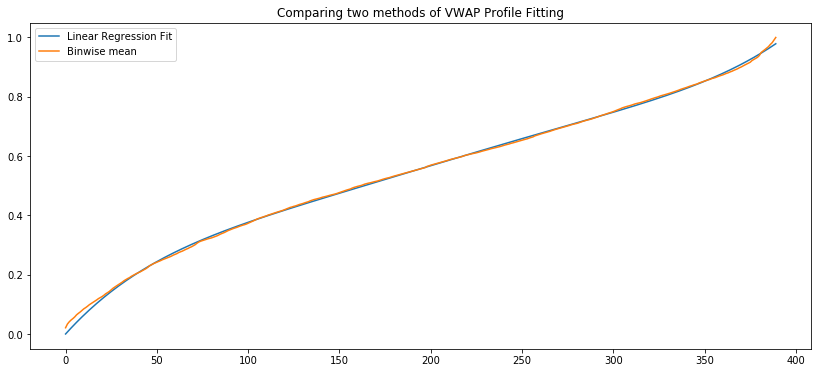

In [29]:
regr_plot = plt.plot( target_pct_regr, label = 'Linear Regression Fit' )
mean_plot = plt.plot( target_pct_mean, label = 'Binwise mean' )
plt.title( 'Comparing two methods of VWAP Profile Fitting' )
plt.legend()

## Let's compare with a single day

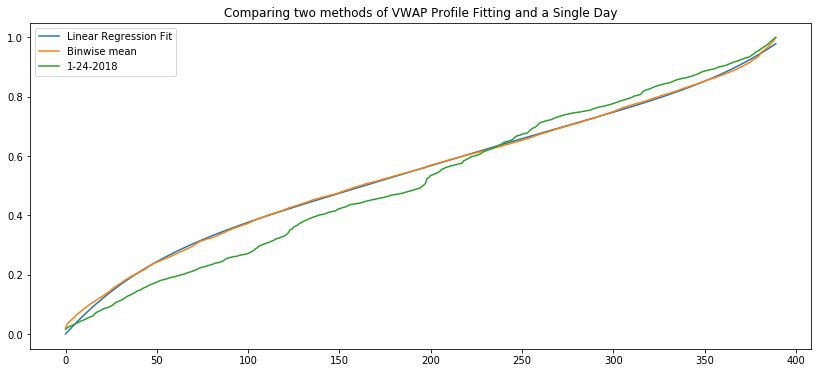

In [30]:
one_day = bar_data[ '1-24-2018' ][ 'accum_pct' ].reset_index( drop = True)

regr_plot = plt.plot( target_pct_regr, label = 'Linear Regression Fit' )
mean_plot = plt.plot( target_pct_mean, label = 'Binwise mean' )
one_day_plot = plt.plot( one_day, label = '1-24-2018' )

plt.title( 'Comparing two methods of VWAP Profile Fitting and a Single Day' )
plt.legend()

## Maybe a different day?

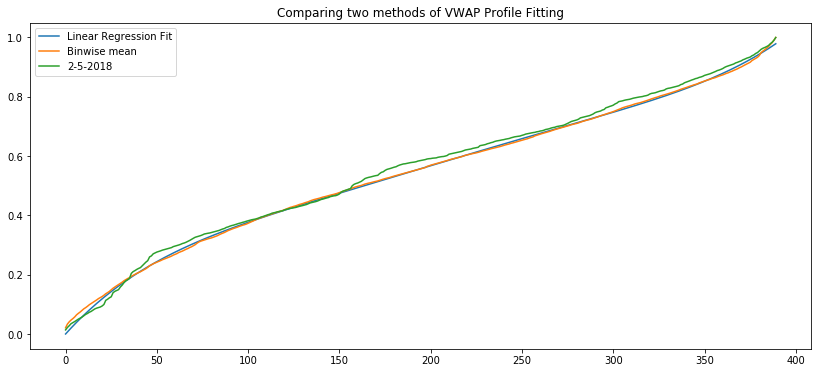

In [36]:
another_day = raw_bar_data[ '2-2-2018' ][ 'accum_pct' ].reset_index( drop = True)

regr_plot = plt.plot( target_pct_regr, label = 'Linear Regression Fit' )
mean_plot = plt.plot( target_pct_mean, label = 'Binwise mean' )
another_day_plot = plt.plot( another_day, label = '2-5-2018' )

plt.title( 'Comparing two methods of VWAP Profile Fitting' )
plt.legend()

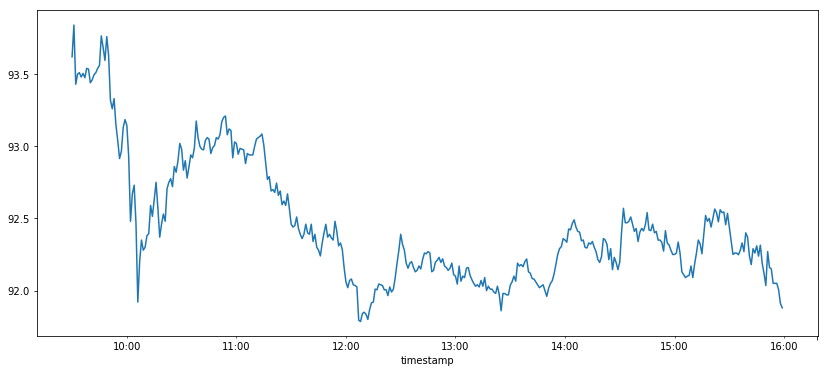

In [37]:
raw_bar_data[ '2-2-2018' ]['close'].plot()